# Master's thesis case study 2: Variable Covariates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import torch
from adaptive_nof1 import *
from adaptive_nof1.policies import *
from adaptive_nof1.helpers import *
from adaptive_nof1.inference import *
from adaptive_nof1.metrics import *
from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Linear Predictor

In [3]:
# Setup generic n-of-1 parameters
length = 20
number_of_patients = 10

In [4]:
# In this case study, we assume a linear predictor for the outcome
# Outcome = (a_x + c * b_x) (a,b parameters, c covariate, X treatment)
number_of_interventions = 2
class LinearPredictorModel(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.a = self.rng.normal(0, 1, size=number_of_interventions)
        self.b = self.rng.normal(0, 1, size=number_of_interventions)
        self.patient_id = patient_id

    @property
    def additional_config(self):
        return {"true_a": self.a, "true_b": self.b}

    @property
    def number_of_interventions(self):
        return len(self.a)
 
    def generate_context(self, history):
        return { "c": self.rng.normal(0, 1) }

    def observe_outcome(self, intervention, context):
        intervention_index = intervention["treatment"]
        print(intervention_index)
        a_k = self.a[intervention_index]
        b_k = self.b[intervention_index]
        return {"outcome": self.rng.normal(a_k + context["c"] * b_k, 1)}

    def __str__(self):
        return f"LinearPredictorModel"

data_generating_model = lambda patient_id: LinearPredictorModel(patient_id)

In [5]:
class LinearPredictorInference(BayesianModel):
    def __str__(self):
        return f"LinearPredictorInference"
    
    def update_posterior(self, history, number_of_treatments):
        df = history.to_df()

        if len(df) == 0:
            df["c"] = []
            df[self.treatment_name] = []
            df["outcome"] = []

        self.model = pymc.Model()
        with self.model:
            treatment_index = pymc.MutableData("treatment_index", pymc.intX(df[self.treatment_name]), dims="observation")
            a = pymc.Normal("a", mu=0, sigma=1, dims="treatment", shape=number_of_treatments)
            b = pymc.Normal("b", mu=0, sigma=1, dims="treatment", shape=number_of_treatments)
            c = pymc.MutableData("c", pymc.floatX(df["c"]), dims="observation")
            outcome = pymc.Normal(
                "outcome", mu=a[treatment_index] + b[treatment_index] * c, observed=df["outcome"], sigma=1, dims="observation",
            )
            decision_boundary = pymc.Deterministic("decision_boundary", (a[0] - a[1]) / (b[1] - b[0]))
            self.trace = pymc.sample(2000, progressbar=False)
            decision_boundary_summary = arviz.summary(self.trace, var_names=["decision_boundary"])
            a_summary = arviz.summary(self.trace, var_names=["a"])
            b_summary = arviz.summary(self.trace, var_names=["b"])
            self._debug_data = {
                "decision_boundary_mean": decision_boundary_summary["mean"].decision_boundary, "decision_boundary_sd": decision_boundary_summary["sd"].decision_boundary,
                "a_mean": a_summary["mean"], "a_sd": a_summary["sd"],
                "b_mean": b_summary["mean"], "b_sd": b_summary["sd"],
            }

    def approximate_max_probabilities(self, number_of_treatments, context):
        assert (
            self.trace is not None
        ), "You called `approximate_max_probabilites` without updating the posterior"

        with self.model:
            pymc.set_data(
                {
                    "treatment_index": pymc.intX(range(number_of_treatments)),
                    "c": pymc.floatX([context["c"]] * number_of_treatments),
                }
            )
            self.trace = pymc.sample_posterior_predictive(self.trace, var_names=["outcome"], extend_inferencedata=True)
            max_indices = np.ravel(
                self.trace.posterior_predictive["outcome"].argmax(
                    dim="observation"
                )
            )
        bin_counts = np.bincount(max_indices, minlength=number_of_treatments)
        return bin_counts / np.sum(bin_counts)

In [6]:
# Inference Model
inference_model = lambda: LinearPredictorInference()

In [7]:
# Policies

fixed_policy = FixedPolicy(
    inference_model = inference_model(),
)


thompson_sampling_policy = ThompsonSampling(
    inference_model=inference_model(),
)

ucb_policy = UpperConfidenceBound(
    inference_model=inference_model(),
    epsilon=0.05,
)


In [8]:
# Full crossover study
study_designs = {
    "n_patients": [number_of_patients],
    "policy": [ucb_policy, fixed_policy, thompson_sampling_policy],
    "model_from_patient_id": [
        data_generating_model,
    ]
}
configurations = generate_configuration_cross_product(study_designs)

In [9]:
ENABLE_SIMULATION = False
if ENABLE_SIMULATION:
    print("Simulation was enabled")
else:
    print("Simulation was disabled")

Simulation was disabled


In [10]:
%%time

if ENABLE_SIMULATION:
    calculated_series, config_to_simulation_data = simulate_configurations(
        configurations, length
    )

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


In [11]:
if ENABLE_SIMULATION:
    write_to_disk("data/2024-02-06-mt_case_study_2a_data.json", [calculated_series, config_to_simulation_data])
else:
    calculated_series, config_to_simulation_data = load_from_disk("data/2024-02-06-mt_case_study_2a_data.json")

In [12]:
class DifferenceToTrueDecisionBoundary(Metric):
    def score(self, data: SimulationData) -> List[float]:
        assert (
            "true_a" in data.additional_config
        )
        assert (
            "true_b" in data.additional_config
        )
        true_a = data.additional_config["true_a"]
        true_b = data.additional_config["true_b"]
        true_decision_boundary = (true_a[0] - true_a[1]) / (true_b[1] - true_b[0])

        return numpy.abs(true_decision_boundary - numpy.array([d["decision_boundary_mean"] for d in data.history.debug_data()]))

    def __str__(self) -> str:
        return "DifferenceToTrueDecisionBoundary"


In [13]:
metrics = [
    CumulativeRegret(),
    DifferenceToTrueDecisionBoundary(),
]
model_mapping = {
    "LinearPredictorModel": "Scenario",
}
policy_mapping = {
    "FixedPolicy": "Fixed",
    "ThompsonSampling(LinearPredictorInference)": "TS",
    "UpperConfidenceBound(0.05 epsilon, LinearPredictorInference)": "UCB",
}

df = SeriesOfSimulationsData.score_data(
    [s["result"] for s in calculated_series], metrics, {"model": lambda x: model_mapping[x], "policy": lambda x: policy_mapping[x]}
)
filtered_df = df.loc[df["t"] == df["t"].max()]
filtered_df

groupby_columns = ["model", "policy"]
pivoted_df = filtered_df.pivot(
    index=["model", "policy", "simulation", "patient_id"],
    columns="metric",
    values="score",
)
table = pivoted_df.groupby(groupby_columns).agg(['mean', 'std'])

table

metric          Cumulative Regret (outcome)             \
                                       mean        std   
model    policy                                          
Scenario Fixed                     3.308156  17.556721   
         TS                       -3.752850  21.681323   
         UCB                      -8.945419  20.349191   

metric          DifferenceToTrueDecisionBoundary             
                                            mean        std  
model    policy                                              
Scenario Fixed                          5.076942  12.947224  
         TS                             0.936542   1.264324  
         UCB                            2.854215   7.198038

In [14]:
with open('mt_resources/6-covariates/01-table.tex', 'w') as file:
    str = table.style.format(precision=2).hide(names=["model"]).to_latex()
    print(str)
    file.write(str)

\begin{tabular}{llrrrr}
 & metric & \multicolumn{2}{r}{Cumulative Regret (outcome)} & \multicolumn{2}{r}{DifferenceToTrueDecisionBoundary} \\
 &  & mean & std & mean & std \\
\multirow[c]{3}{*}{Scenario} & Fixed & 3.31 & 17.56 & 5.08 & 12.95 \\
 & TS & -3.75 & 21.68 & 0.94 & 1.26 \\
 & UCB & -8.95 & 20.35 & 2.85 & 7.20 \\
\end{tabular}



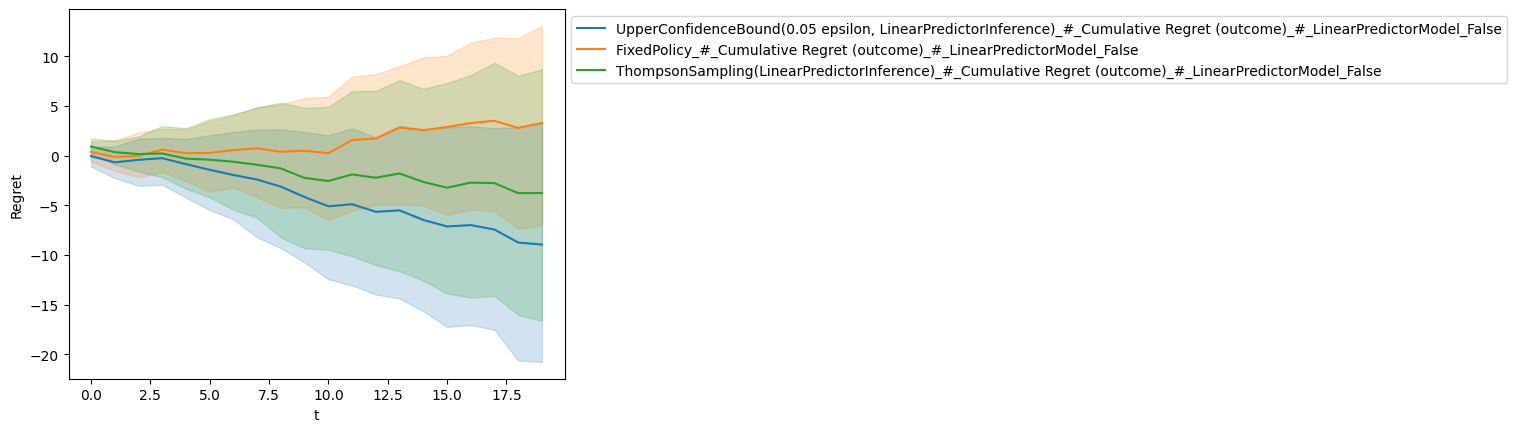

In [15]:
SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series if s["configuration"]["model"] == "LinearPredictorModel"],
    [
        CumulativeRegret(),
    ],
    legend_position=(1,1),
)
plt.savefig("mt_resources/6-covariates/01_cumulative_regret.pdf", bbox_inches="tight")

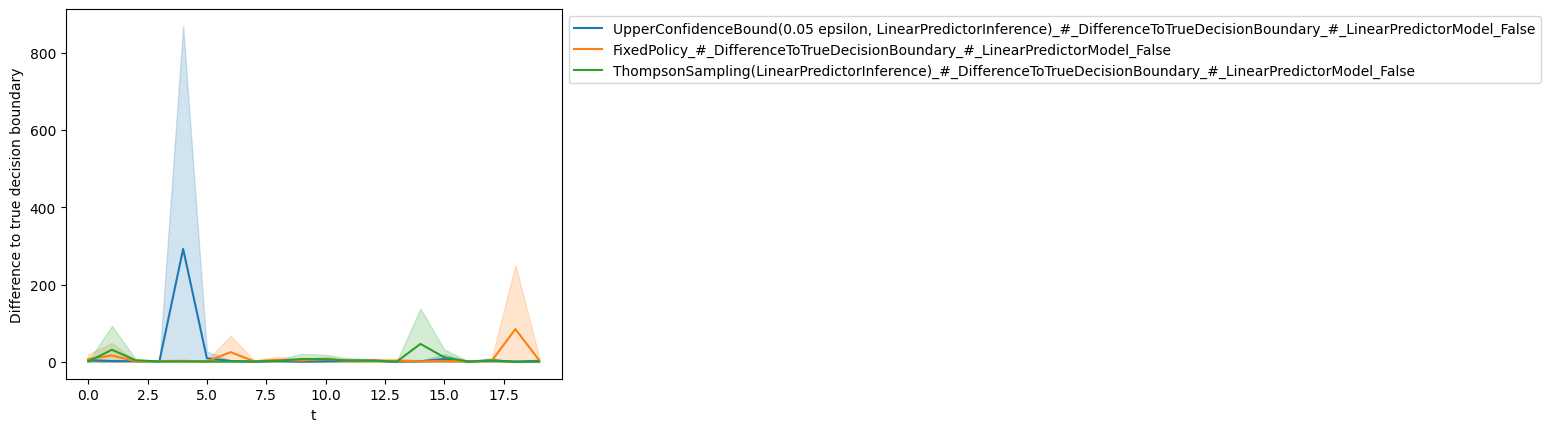

In [16]:
SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series if s["configuration"]["model"] == "LinearPredictorModel"],
    [
        DifferenceToTrueDecisionBoundary(),
    ],
    legend_position=(1,1),
)
plt.ylabel("Difference to true decision boundary")
plt.savefig("mt_resources/6-covariates/01_difference-decision-boundary.pdf", bbox_inches="tight")

In [18]:
plot_allocations_for_calculated_series(calculated_series)

/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .HeatMap.I   :HeatMap   [t,patient_id]   (color_index,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .Overlay.I   :Overlay
      .Rectangles.I  :Rectangles   [x0,y0,x1,y1]   (value)
      .Text.I        :Text   [x,y]
      .Rectangles.II :Rectangles   [x0,y0,x1,y1]   (value)
      .Text.II       :Text   [x,y]
   .HeatMap.II  :HeatMap   [t,patient_id]   (color_index,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .Overlay.II  :Overlay
      .Rectangles.I  :Rectangles   [x0,y0,x1,y1]   (value)
      .Text.I        :Text   [x,y]
      .Rectangles.II :Rectangles   [x0,y0,x1,y1]   (value)
      .Text.II       :Text   [x,y]
   .HeatMap.III :HeatMap   [t,patient_id]   (color_index,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .Overlay.III :Overlay
      .Rectangles.I  :Rectangles   [x0,y0,x1,y1]   (value)
      .Text.I        :Text   [x,y]
      .Rectangles.II :Rectangles   [x0,y0,x1,y1]   (value)
      .Text.II       :Text   [x,y]